# Financial Time Series Analysis: Programming Tutorial [PART II]

Course material for CMU 46-929, Spring 2023 (Instructor: Arun Kumar Kuchibhotla).

Written & presented by YJ Choe ([yjchoe@cmu.edu](mailto:yjchoe@cmu.edu)).

---

In this tutorial, we will go over the basics of time series modeling, focusing on actual Python code snippets.

### Part I: Diagnostics, Trend Fitting, and Seasonal Decomposition

See notebook [`Tutorial-01-SeasonalDecomposition.ipynb`](Tutorial-01-SeasonalDecomposition.ipynb).

### Part II: Model-Free Nonparametric Prediction

- [Review: Model-Free Linear Prediction for Stationary Time Series](#Review:-Model-Free-Linear-Prediction-for-Stationary-Time-Series)
- [Model-Free Nonparametric Prediction for Non-stationary Time Series](#Model-Free-Nonparametric-Prediction-for-Non-stationary-Time-Series)
    - [Local Linear Regression](#Local-Linear-Regression)
    - [Mean Forecasting with Local Linear Regression](#Mean-Forecasting-with-Local-Linear-Regression)
    - [Hyperparameter Tuning on a Validation Set](#Hyperparameter-Tuning-on-a-Validation-Set)
    - [Computing a Prediction Interval](#Computing-a-Prediction-Interval)
- [Forecasting](#Forecasting)

### Part III: The ARMA Family of Models: $\mathrm{MA}(q)$, $\mathrm{AR}(p)$, and $\mathrm{ARMA}(p, q)$

See notebook [`Tutorial-03-ARIMA.ipynb`](Tutorial-03-ARIMA.ipynb).


---

## Setup

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tools.eval_measures import mse

In [113]:
"""
Utility functions
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# 2023 fix
import pandas_datareader.data as pdr
import yfinance as yf


# yf.pdr_override() # causes error 2025


FIGSIZE = (12, 4)
PLOT_STYLE = "seaborn-v0_8-colorblind"


def tsplot(
        y,
        title="",
        lags=None,
        figsize=(FIGSIZE[0], 2 * FIGSIZE[1]),
        style=PLOT_STYLE,
):
    """Plot a time series with a QQ-plot and an autocorrelation plot."""
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (1, 0))
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.qqplot(y, line="s", ax=qq_ax)
        qq_ax.set_title("Normal QQ-plot")
        fig.tight_layout()


def compute_returns(
        y,
        symbol,
        period=1,
        use_relative=False,
        use_log=True,
        plot=False,
        **plot_kwargs,
) -> pd.Series:
    """Compute the (relative) (log-)returns of a time series."""
    assert not (use_relative and use_log), \
        "can only compute either relative or log returns"
    if use_relative:
        returns = (y.diff(period) / y.shift(period)).dropna()
        name = "RelativeReturns"
    else:
        returns = (y / y.shift(period)).dropna()
        name = "Returns"
        if use_log:
            returns = np.log(returns)
            name = "LogReturns"

    returns = returns[::period]
    returns.rename(name, inplace=True)

    if plot:
        days_str = f"{period}-day" if period > 1 else "Daily"
        tsplot(
            returns,
            title=f"{days_str} {name}: {symbol}",
            **plot_kwargs,
        )
    return returns


def get_returns_yahoo(
        symbol,
        start,
        end,
        n_days=1,
        use_log=True,
        plot=False,
        **plot_kwargs,
) -> pd.Series:
    """Retrieve and (optionally) plot
    the `n_days`-day (log-)returns of a stock."""
    price = pdr.get_data_yahoo(symbol, start, end)
    adjclose = price["Adj Close"]
    returns = (adjclose / adjclose.shift(n_days)).dropna()
    if use_log:
        returns = np.log(returns)

    returns = returns[::n_days]
    name = "LogReturns" if use_log else "Returns"
    if n_days > 1:
        name += f"{n_days}Day"
    returns.rename(name, inplace=True)

    if plot:
        days_str = f"{n_days}-day" if n_days > 1 else "Daily"
        log_str = "log-" if use_log else ""
        tsplot(
            returns,
            title=f"{days_str} {log_str}returns: {symbol}",
            **plot_kwargs,
        )
    return returns


def read_ts_data(csv_filename, time_column,
                 start=None, end=None, sort_index=True):
    """Read a time series dataset in a csv file
    (e.g., from the Wall Street Journal page)."""
    df = pd.read_csv(csv_filename).set_index(time_column)
    # set index to a datetime
    df.index = pd.to_datetime(df.index)
    # strip columns of whitespaces
    df.columns = [col.strip() for col in df.columns]
    if start is not None:
        df = df[df.index >= start]
    if end is not None:
        df = df[df.index <= end]
    return df.sort_index() if sort_index else df


def get_airline_passengers(
        start,
        end,
        use_log=False,
        plot=False,
        url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv",
        **plot_kwargs,
) -> pd.Series:
    """Retrieve and (optionally) plot the monthly airline passengers dataset."""
    passengers = pd.read_csv(url).set_index("Month")
    # get DatetimeIndex(freq="MS")
    passengers.index = pd.to_datetime(passengers.index).to_period().to_timestamp()
    passengers = passengers.loc[start:end, "Passengers"]
    if use_log:
        passengers = np.log(passengers)
    if plot:
        log_str = "Log of " if use_log else ""
        tsplot(
            passengers,
            log_str + "Number of monthly airline passengers (thousands)",
            **plot_kwargs,
        )
    return passengers

In [114]:
"""
time series forecasters
"""

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from scipy.linalg import toeplitz
from numpy.lib.stride_tricks import sliding_window_view

from statsmodels.nonparametric.kernel_regression import KernelReg

from typing import Tuple
from tqdm import trange


class ModelFreeLinearPredictor:
    """Best linear predictor for model-free time series forecasting.

    Note:
        This implementation relies on computing
        the inverse of a (sqrt(T), sqrt(T))-shaped toeplitz matrix.
        For large T, see, e.g., the Durbin-Levinson algorithm.

    Args:
        xs: input time series for model fitting
        window_size: size of the lookback window
            (how many past time points to use as covariates)
            Default: sqrt(len(xs)).

    Attributes (most computed lazily in `self.fit()`):
        t: length of xs
        window_size: number of past values used for prediction
        acorr: autocorrelation on xs
        mu: mean of xs
        Gamma: the (sqrt(T), sqrt(T)) autocorrelation matrix of predictors
        Gamma_inv: the inverse of Gamma.
    """
    def __init__(
            self,
            xs: pd.Series,
            window_size: int = None,
    ):
        self.xs = xs if isinstance(xs, pd.Series) else pd.Series(xs)

        assert self.xs.index.is_monotonic_increasing
        self.t = len(xs)
        if window_size is None:
            self.window_size = int(np.ceil(np.sqrt(self.t))) + 1  # 0, 1, ..., [sqrt(T)]
        else:
            assert window_size < self.t
            self.window_size = window_size

        # lazy evaluation
        self.acorr = None
        self.mu = None
        self.Gamma = None
        self.Gamma_inv = None

    def fit(self):
        """Fit the linear model by precomputing the mean and the autocorrelation,
        constructing the Gamma matrix, and computing its inverse.

        Returns `self`.
        """
        self.mu = np.mean(self.xs)
        self.acorr = tsa.acf(self.xs, nlags=self.t + 1)  # store all acorr's
        # below is a custom implementation of the acf function (same results):
        # def compute_acorr(xs, nlags=30):
        #     """Compute the mean and the autocorrelation functions."""
        #     mu = np.mean(xs)
        #     acov = np.zeros(nlags + 1)
        #     acov[0] = np.var(xs)
        #     for h in range(1, nlags + 1):
        #         acov[h] = ((xs - mu) * (xs.shift(h) - mu)).dropna().mean()
        #     acorr = acov / acov[0]
        #     return mu, acorr

        # one-liner for constructing Gamma
        self.Gamma = toeplitz(self.acorr[:self.window_size])
        # constructing it manually is also fine (less efficient, though): e.g.,
        # self.Gamma = np.array([
        #     np.concatenate([self.acorr[1:t + 1][::-1],
        #                     self.acorr[:self.window_size - t]])
        #     for t in range(self.window_size)
        # ])
        self.Gamma_inv = np.linalg.inv(self.Gamma)  # may be slow for large T!
        return self

    def predict_in_sample(self, k: int = 1) -> pd.Series:
        """Make predictions *in-sample*,
        i.e., X_{[sqrt(T)]+1}, X_{[sqrt(T)]+2}, ..., X_T.

        Note that the value of k is fixed in this case.
        """
        # larger lags first (reversed)
        eta = self.acorr[k : self.window_size + k][::-1]
        beta = self.Gamma_inv.dot(eta)
        alpha = self.mu * (1 - beta.sum())

        X = sliding_window_view(self.xs, self.window_size)[:-k, :]
        predictions_in_sample = alpha + X.dot(beta)
        t_index = self.xs.index[self.window_size + k - 1:]
        assert len(predictions_in_sample) == len(t_index)
        return pd.Series(predictions_in_sample, index=t_index)

    def forecast(
            self,
            start: int = 1,
            end: int = 31,
            t_index: pd.Index = None,
    ) -> pd.Series:
        """Predict X_{T+k} for k = start, ..., end - 1.

        If `index` is provided, it is interpreted as the range for k.
        In this case, `start` and `end` are ignored.

        Maximum forecast horizon is the number of training data points (`t`).

        *Warning:* k starts from 1 and not zero.
        """

        # Use either index or (start, end) and adjust the other
        if t_index is not None:
            start, end = 1, len(t_index) + 1
        else:
            t_index = np.arange(start, end)

        # Vectorized prediction for k = start, ..., end - 1.
        # each column of etas is eta[k]. (vector; larger lags first)
        etas = np.vstack([
            self.acorr[k : k + self.window_size][::-1]
            for k in range(start, end)
        ]).T
        betas = self.Gamma_inv.dot(etas)
        alpha = self.mu * (1 - betas.sum(axis=0))
        X = self.xs[-self.window_size:].to_numpy()
        predictions = alpha + X.dot(betas)

        return pd.Series(data=predictions, index=t_index)


class ModelFreeNonparametricPredictor:
    """Model-free nonparametric prediction of a time series
    using a fixed window.

    The nonparametric predictor is a local linear regression (LLR).
    (`statsmodels.nonparametric.kernel_regression.KernelReg`)

    Optionally computes a prediction interval for forecasts,
    using a second nonparametric volatility forecaster.

    Each lag (k) is treated separately.
    """

    def __init__(
            self,
            xs: pd.Series,
            window_size: int = None,
            max_k: int = 12,
            kernel: str = "gaussian",
            bandwidth: float = None,
            compute_interval: bool = True,
    ):
        self.xs = xs
        assert self.xs.index.is_monotonic_increasing
        self.t = len(xs)
        if window_size is None:
            self.window_size = int(np.ceil(np.sqrt(self.t))) + 1  # 0, 1, ..., [sqrt(T)]
            if self.window_size > 20:
                print(f"warning: nonparametric regression may be too slow"
                      f"for larger window sizes (got: {self.window_size})")
        else:
            assert window_size < self.t
            self.window_size = window_size
        # sliding window of the time series (the design matrix)
        self.windows = sliding_window_view(self.xs, self.window_size)

        self.max_k = max_k
        self.kernel = kernel
        self.bandwidth = bandwidth
        if isinstance(self.bandwidth, float):
            self.bandwidth = [self.bandwidth for _ in range(self.window_size)]
        self.compute_interval = compute_interval

        # lazily initialize one forecaster per lag
        self.mean_forecasters = {k: None for k in range(1, max_k + 1)}
        self.vol_forecasters = {k: None for k in range(1, max_k + 1)}

        # last w data points are the input to the predictions
        self.predictors = self.windows[-1]
        # each column is each k value
        self.predictions_in_sample = pd.DataFrame(
            columns=pd.RangeIndex(1, max_k + 1, name="k"))
        # quantiles are populated in fit() and used for prediction intervals
        self.quantiles_in_sample = {k: [] for k in range(1, max_k + 1)}

    def fit(self, verbose: bool = False):
        """'Fit' a nonparametric regression model with the specified window size.

        If `self.compute_interval == True`, the method also fits
        a volatility forecaster and uses it to compute
        the empirical quantiles of standardized residuals
        (used for prediction intervals).

        Returns `self`.
        """
        if verbose:
            k_range = trange(1, self.max_k + 1, desc="local linear regression")
        else:
            k_range = range(1, self.max_k + 1)
        for k in k_range:
            X_k = self.windows[:-k, :]
            y_k = self.xs[self.window_size + k - 1:].to_numpy()
            assert len(X_k) == len(y_k)

            # mean prediction via local linear regression
            mean_fct = KernelReg(
                y_k,
                X_k,
                var_type="c" * self.window_size,
                reg_type="ll",
                ckertype=self.kernel,
                bw=self.bandwidth if self.bandwidth is not None else "cv_ls",
            )
            self.mean_forecasters[k] = mean_fct

            # volatility prediction via local linear regression (separately)
            # TODO: allow separate bandwidths for mean and volatility predictors
            if self.compute_interval:
                mean_preds = self.predict_in_sample(k=k)
                residuals = y_k - mean_preds
                # fit volatility (absolute residuals)
                vol_fct = KernelReg(
                    np.abs(residuals),
                    X_k,
                    var_type="c" * self.window_size,
                    reg_type="ll",
                    ckertype=self.kernel,
                    bw=self.bandwidth if self.bandwidth is not None else "cv_ls",
                )
                self.vol_forecasters[k] = vol_fct

                # precompute empirical quantiles of standardized residuals
                vol_preds, _ = vol_fct.fit(X_k)
                self.quantiles_in_sample[k] = \
                    (residuals / vol_preds).sort_values().to_numpy()

        # predictors for future forecasts
        self.predictors = self.windows[-1, :]
        return self

    def predict_in_sample(self, k: int = 1) -> pd.Series:
        """Make mean predictions *in-sample*,
        i.e., X_{[sqrt(T)]+1}, X_{[sqrt(T)]+2}, ..., X_T.

        Note that the value of k is fixed in this case.
        """
        assert 1 <= k <= self.max_k
        # avoid re-computing if already available
        if not self.predictions_in_sample[k].dropna().empty:
            return self.predictions_in_sample[k]

        X_k = self.windows[:-k, :]
        # prediction on the entire input sample X
        predictions_in_sample, _ = self.mean_forecasters[k].fit(X_k)
        t_index = self.xs.index[self.window_size + k - 1:]
        predictions_in_sample = pd.Series(predictions_in_sample,
                                          index=t_index)

        # store predictions to avoid re-computation
        self.predictions_in_sample[k] = predictions_in_sample
        return predictions_in_sample

    def forecast(
            self,
            start: int = 1,
            end: int = 12,
            t_index: pd.Index = None,
            predictors: np.ndarray = None,
            alpha: float = 0.05,
    ) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """Predict X_{T+k} given predictors (X_T, X_{T-1}, ..., X_{T-window_size}),
        for k = start, ..., end - 1.

        If `X_pred` is `None`, then
        prediction is made using the last `window_size` points from the training data.

        `start` and `end` denote the forecasting horizon,
        following the last date of the predictors `X_pred`.

        If `t_index` is provided, it is interpreted as the date range for k.
        In this case, `start` and `end` are ignored.

        *Warning:* k starts from 1 and not zero.
        """
        assert 1 <= start <= end - 1 <= self.max_k

        # Use either index or (start, end) and adjust the other
        if t_index is not None:
            start, end = 1, len(t_index) + 1
        else:
            t_index = np.arange(start, end)

        # make k-step-ahead forecasts
        predictors = self.predictors if predictors is None else predictors
        mean_predictions = [
            self.mean_forecasters[k].fit(predictors)[0].item()
            for k in range(start, end)
        ]
        mean_predictions = pd.Series(mean_predictions, index=t_index)

        if self.compute_interval:
            # compute sigma-hat
            vol_predictions = [
                self.vol_forecasters[k].fit(predictors)[0].item()
                for k in range(start, end)
            ]
            vol_predictions = pd.Series(vol_predictions, index=t_index)

            # compute in-sample standardized residuals for quantiles
            z_lo, z_hi = [], []
            for k in range(start, end):
                quantiles_k = self.quantiles_in_sample[k]
                n_quantiles = len(quantiles_k)
                q_lo = int(np.floor(n_quantiles * alpha / 2))
                q_hi = int(np.ceil(n_quantiles * (1 - alpha / 2)))
                z_lo.append(quantiles_k[q_lo])
                z_hi.append(quantiles_k[q_hi])

            pi_lower = mean_predictions + z_lo * vol_predictions
            pi_upper = mean_predictions + z_hi * vol_predictions

            if (pi_lower > pi_upper).any():
                print("WARNING: volatility predictions may be null")

        else:
            pi_lower, pi_upper = None, None

        return mean_predictions, pi_lower, pi_upper

In [115]:
# set styles globally for matplotlib and seaborn
FIGSIZE = (12, 4)
PLOT_STYLE = "seaborn-v0_8-colorblind"

plt.style.use(PLOT_STYLE)
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.5,
)

In [116]:
rng = np.random.default_rng(20230327)

## Data: USD-CNY Exchange Rate

As before, we look at the USD-to-CNY exchange rate ([data from WSJ](https://www.wsj.com/market-data/quotes/fx/USDCNY/historical-prices)).
We focus on the data from 2021-12-01 to 2022-12-14 and try to forecast the stock prices from 2022-12-15 to 2022-12-31.

The last 14 days of the training data is used as the _validation_ set, which we will later need for tuning the hyperparameters.

In [117]:
# training data
TRAIN_START_DATE = "2019-03-14" # "2021-12-01"
TRAIN_END_DATE = "2022-11-30"

# validation set (for hyperparameter tuning)
VAL_START_DATE = "2022-12-01"
VAL_END_DATE = "2022-12-14"

# test set (11 business days)
TEST_START_DATE = "2022-12-15"
TEST_END_DATE = "2022-12-31"

In [118]:
SYMBOL = "USDCNY"
PERIOD = 1
MAX_HORIZON = 12  # maximum forecasting horizon

In [119]:
prices_train = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=TRAIN_START_DATE,
    end=TRAIN_END_DATE,
)["Close"]

print("training data size:", len(prices_train))

training data size: 970


<ipython-input-113-f24f0c8d120e>:122: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


The plot below shows that the time series is highly non-stationary with sharp changes and different volatility levels here and there.

,Close
Date,
2019-03-14,6.7229
2019-03-15,6.7135
2019-03-18,6.7130
2019-03-19,6.7119
2019-03-20,6.6945


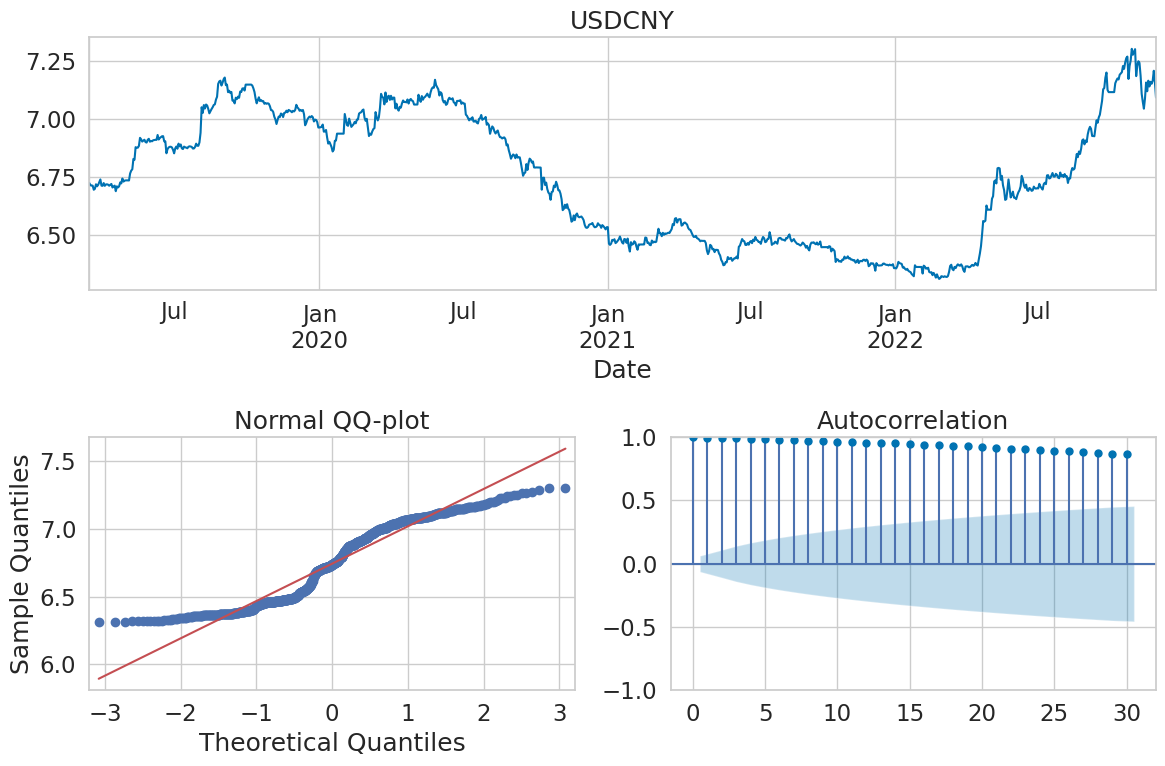

In [120]:
tsplot(prices_train, title=SYMBOL)
prices_train.head()

We also compute and plot the log-returns on this time series.

Finally, we also analogously read in the validation (from 12/01/2022 to 12/14/2022) and test (from 12/15/2022 to 12/31/2022) data.

In [121]:
# retrieve one earlier day to compute the log-returns
prices_val = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=pd.to_datetime(VAL_START_DATE) - timedelta(days=1),
    end=VAL_END_DATE,
)["Close"]
log_returns_val = compute_returns(
    prices_val,
    symbol=SYMBOL,
    period=PERIOD,
    use_log=True,
)
prices_val = prices_val.iloc[1:]

<ipython-input-113-f24f0c8d120e>:122: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


In [122]:
# retrieve one earlier day to compute the log-returns
prices_test = read_ts_data(
    f"data/{SYMBOL}_WSJ_HistoricalPrices.csv",
    "Date",
    start=pd.to_datetime(TEST_START_DATE) - timedelta(days=1),
    end=TEST_END_DATE,
)["Close"]

# 12/15/2022 to 12/31/2022
log_returns_test = compute_returns(
    prices_test,
    symbol=SYMBOL,
    period=PERIOD,
    use_log=True,
)
prices_test = prices_test.iloc[1:]

<ipython-input-113-f24f0c8d120e>:122: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


In [123]:
PRICE_NAME = "Prices"

## Review: Model-Free Linear Prediction for Stationary Time Series

We first review the model-free prediction approach using the best linear predictor, which we derived from lecture 3 and HW2.

Given a real-valued time series $(X_t)_{t\geq 0}$, consider the problem of predicting the next value $X_{t+1}$ using the past $w$ data points, ${\bf X}_{past} = (X_t, X_{t-1}, \dotsc, X_{t-w+1})$, where $w \in \mathbb{N}$ is the size of the lookback window.
In the lectures, we have used $w = [\sqrt{T}] + 1$, where $T$ is the number of available data points.
For $k$-step-ahead prediction, we predict $X_{t+k}$ using the same past $w$ data points ${\bf X}_{past}$.

The _best predictor_ w.r.t. the squared prediction risk, $R(f) = \mathbb{E}[(X_t - f({\bf X}_{past})^2]$, is given by
$$
\mu({\bf X}_{past}) = \mathbb{E}[X_t \mid {\bf X}_{past}] = \mathbb{E}[X_t \mid X_{t-1}, \dotsc, X_{t-w}].
$$
(For more on this, see, e.g., [here](https://www.stat.cmu.edu/~larry/=stat700/Lecture19.pdf).)

The best **linear** predictor, which is a linear function that minimizes the squared prediction risk, is given by
$$
\mu_{blp}({\bf X}_{past}) = \alpha^* + \sum_{j=0}^{w-1} \beta_j^* X_{t-j},
$$
where
$$
\alpha^* = \mathbb{E}[X_{t+1}] -  \sum_{j=0}^{w-1} \beta_j^* \mathbb{E}[X_{t-j}]
$$
and
$$
\beta^* = \Gamma^{-1} \gamma.
$$
Here,$\Gamma = [\mathrm{Cov}(X_{t-j}, X_{t-k})]_{j,k=0}^{w-1}$ and $\gamma = [\mathrm{Cov}(X_{t+1}, X_{t-j})]_{j=0}^{w-1}$.
In HW2, you are asked to show that estimates of $\alpha^*$ and $\beta^*$ can be obtained by using (estimates of) the mean $\mu$ and autocorrelation $\rho$ functions for $(X_t)_{t\geq0}$, **assuming (weak) stationarity**.
Recall that $(X_t)_{t\geq0}$ is weakly stationary if it has constant mean and autocorrelation functions, irrespective of time:
$$
\mathbb{E}[X_t] = \mu \quad \text{and} \quad \mathrm{Cov}(X_t, X_{t-k}) = \gamma(k) = \gamma(0)\rho(k),
$$
for all $t \geq 0$ and $0 \leq k \leq t$, and $\gamma(0) = \sigma^2 < \infty$.

This predictor is "model-free", in the sense that it does not actually assume any model for the time series $(X_t)_{t\geq 0}$, except for stationarity. (It's the best we can do with such a linear predictor, but we do not assume that the actual data-generating process follows a linear model.)

In the following, we show the MSE of the best linear predictor on the USD-CNY validation set, where the window size is set to $w = [\sqrt{T}]+1$, where $T$ is the training data size.

The implementation of `ModelFreeLinearPredictor` will be released as part of HW2 solutions.

In [124]:
linear_model = ModelFreeLinearPredictor(prices_train)
linear_model.fit()
preds_lm_val = linear_model.forecast(t_index=prices_val.index)
mse_lm_val = mse(preds_lm_val, prices_val)
print("Validation MSE, best linear predictor: {:.5f}".format(mse_lm_val))

Validation MSE, best linear predictor: 0.00501


## Model-Free Nonparametric Prediction for Non-stationary Time Series

In this tutorial, we go one step further and replace the linear predictor with a **nonparametric predictor**.
In doing so, we will also replace the stationarity assumption with something weaker.
Here, the term "nonparametric" loosely refers to the fact that we are not using a flexible prediction method that do not assume a restrictive structure on $f$, such as linearity.
(See [here](https://www.stat.cmu.edu/~larry/=sml/NonparRegression.pdf) or the book [_All of Nonparametric Statistics_ by Larry Wasserman](https://link.springer.com/book/10.1007/0-387-30623-4) for more details.)

Following the definition of the best predictor from before, we now estimate the regression function
$$
\mu({\bf X}_{past}) = \mathbb{E}[X_{t+1} \mid {\bf X}_{past}] = \mathbb{E}[X_{t+1} \mid X_t, X_{t-1}, \dotsc, X_{t-w+1}]
$$
with a flexible (i.e., nonlinear) function. Note that $m$ is a $w$-dimensional function: the larger the size of the lookback window, the more high-dimensional it gets.
For $k$-step-ahead forecasts, we analogously estimate $\mathbb{E}[X_{t+k} \mid {\bf X}_{past}]$.

Given a time series $X_1, \dotsc, X_T$, we can construct the design matrix and the output vector to this regression problem as follows:
$$
{\bf W} =
\begin{bmatrix}
X_1 & \dotsb & X_{w} \\
X_2 & \dotsb & X_{w+1} \\
\vdots & \cdots & \vdots\\
X_{T - w} & \dotsb & X_{T - 1} \\
\end{bmatrix}, \quad
{\bf y} = \begin{bmatrix}
X_{w+1} \\
X_{w+2} \\
\vdots \\
X_T \\
\end{bmatrix}.
$$
We call ${\bf W}$ the _sliding window design matrix_. Each row of ${\bf W}$ represents one ${\bf X}_{past}$, and each row of ${\bf y}$ represents one $X_{t+1}$.
The number of rows in both ${\bf W}$ and ${\bf y}$ is $T - w$; the analogs for $k$-step-ahead forecasts would have $T - w - (k-1)$ rows.

Before proceeding further, we quickly show how this matrix-vector pair can be constructed in code.

In [125]:
from numpy.lib.stride_tricks import sliding_window_view

T = len(prices_train)
window_size = 5
k = 1

# equivalent to:
# windows = np.array([prices_train[i:i+window_size]
#                     for i in range(T - window_size - (k - 1))])
windows = sliding_window_view(prices_train, window_size)[:-k]
outputs = prices_train[window_size + k - 1:]
print(T, windows.shape, outputs.shape)
print("inputs:", windows[:4])
print("outputs:", outputs[:4].to_numpy())

970 (965, 5) (965,)
inputs: [[6.7229 6.7135 6.713  6.7119 6.6945]
 [6.7135 6.713  6.7119 6.6945 6.6984]
 [6.713  6.7119 6.6945 6.6984 6.7181]
 [6.7119 6.6945 6.6984 6.7181 6.7094]]
outputs: [6.6984 6.7181 6.7094 6.7157]


Now that we have the design matrix and the output vector, we can proceed as if we have a standard regression setup.

### Local Linear Regression

Many, many methods exist for how to estimate $\mu$ nonparametrically^, although no method is perfect for every situation.
In this notebook, we focus on one particular method called **local linear regression (LLR)**.

Intuitively, LLR performs a weighted linear regression within _each local neighborhood_ of the input, where points closer to the input are given more weight.
Because the linear fit is done locally at each point of prediction, the resulting estimate of the regression function can be (highly) nonlinear.

To formally introduce LLR, it is easier to first introduce the _(Nadaraya-Watson) kernel regression/smoothing_.
Given $n$ input data points ${\bf w}_1, \dotsc, {\bf w}_n \in \mathbb{R}^d$ and outputs $y_1, \dotsc, y_n \in \mathbb{R}$ (think back to the data matrix/vector we constructed just above), the kernel regression function is given by:
$$
\hat{m}_{kr}({\bf w}) = \frac{\sum_{i=1}^n y_i K_h({\bf w}_i - {\bf w})}{\sum_{i=1}^n K_h({\bf w}_i - {\bf w})}, \quad {\bf w} \in \mathbb{R}^d,
$$
where $K_h$ is a _smoothing kernel_ that defines a weight for each input based on some distance metric (closer points get larger weights).
This is essentially a **locally weighted moving average of the outputs**, where the weights are based on neighboring inputs in the data.

For the choice of the kernel function $K_h$, we use the Gaussian kernel:
$$
K_h({\bf w}_i - {\bf w}) = \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{||{\bf w}_i - {\bf w}||_2^2}{2h^2} \right).
$$
$h > 0$ is the _bandwidth_ parameter, which controls the smoothness of the resulting fit (larger $h$ -> smoother fit).
More kernel choices can be found [here](https://en.wikipedia.org/wiki/Kernel_(statistics)#Nonparametric_statistics).

LLR is an improvement over kernel regression, as the latter is known to incur certain statistical biases.
It turns out that kernel regression can be viewed as fitting a _constant_ function in a local neighborhood of each input, such that it minimizes a weighted squared loss of the following form:
$$
\hat{m}_{kr}({\bf w}) = \arg\min_{c \in \mathbb{R}} \sum_{i=1}^n K_h({\bf w}_i - {\bf w}) (y_i - c)^2.
$$
LLR replaces this constant fit with a linear fit:
$$
\hat{m}_{llr}({\bf w}) = \alpha^*({\bf w}) + \langle \beta^*({\bf w}), {\bf w} \rangle,
$$
where
$$
(\alpha^*({\bf w}), \beta^*({\bf w})) = \arg\min_{\alpha \in \mathbb{R}, \beta \in \mathbb{R}^d} \sum_{i=1}^n K_h({\bf w}_i - {\bf w}) (y_i - \alpha({\bf w}) - \langle \beta^*({\bf w}), {\bf w}_i \rangle)^2.
$$
Note that, unlike in standard linear regression, the minimizers depend on each input ${\bf w}$, so they need to be computed for each test input ${\bf w}$.
Fortunately, a closed-form expression for the minimizer can be derived --- with a caveat that the closed form involves inverting a $n \times n$ matrix, which can be slow for large $n$.
In our use case ($n \approx 1,000$), this computation is doable relatively easily.

#### ^Aside: Other Nonparametric Prediction Methods

Given our "model-free" approach, any other regression method could be subbed in for kernel or local linear regression.
Examples include splines, kernel ridge regression, generalized additive models, random forests, boosting, and neural networks.

Our choice is largely based on the simplicity of explanation and the implementations available on the `statsmodels` package.

Here are some other packages to check out for different kinds of nonparametric predictors:
- [`scikit-learn`](https://scikit-learn.org/) and its time-series extension, [`sktime`](https://sktime.readthedocs.io/en/stable/): nearest neighbors regression, kernel ridge regression and SVMs, random forests
- [`XGBoost`](https://xgboost.readthedocs.io/en/stable/): efficient gradient boosting-based methods
- [`PyGAM`](https://pygam.readthedocs.io/en/latest/): generalized additive models (also see [`statsmodels`'s GAM module](https://www.statsmodels.org/dev/gam.html))
- [`NeuralProphet`](https://neuralprophet.com/): for deep learning-based extensions

### Mean Forecasting with Local Linear Regression

Returning to local linear regression, the following code implements LLR on the sliding window data that we just constructed and produces mean forecasts on the validation set.
Here, we fit separate LLRs for $k = 1, 2, \dotsc, 10$ (size of the validation set).
This is enough to give us a model-free nonparametric mean forecasts for the forecasting horizon.

A version of the following code is implemented in `forecasters.py` as `ModelFreeNonparametricPredictor`.
Similar to the linear variant, it implements two key methods: `fit()` and `forecast()`.

In [126]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# heuristically chosen for now
window_size = 10
bandwidth = 0.1

windows = sliding_window_view(prices_train, window_size)

mean_forecasters = {}
mean_forecasts = []
# prediction on the validation set
for k in np.arange(1, len(prices_val) + 1):
    # construct design matrix and output vector for k-step prediction
    X_k = windows[:-k, :]
    y_k = prices_train[window_size + k - 1:].to_numpy()
    assert len(X_k) == len(y_k)

    # mean predictor via local linear regression
    mean_forecasters[k] = KernelReg(
        y_k,
        X_k,
        var_type="c" * window_size,      # all inputs are 'c'ontinuous
        reg_type="ll",                   # local linear regression
        ckertype="gaussian",             # gaussian kernel
        bw=[bandwidth] * window_size,    # one per input dimension
    )

    # k-step prediction using the last available "past" (X_{T-w+1}, ..., X_T)
    mean_pred, _ = mean_forecasters[k].fit(windows[-1])
    mean_forecasts.append(mean_pred.item())

mean_forecasts = pd.Series(mean_forecasts, index=prices_val.index, name="Pred")
pd.concat([mean_forecasts, prices_val], axis=1)

,Pred,Close
Date,,
2022-12-01,7.107007,7.0444
2022-12-02,7.086344,7.0246
2022-12-05,7.087708,6.9620
2022-12-06,7.070048,6.9960
2022-12-07,7.060849,6.9735
2022-12-08,7.050574,6.9674
2022-12-09,7.038445,6.9578
2022-12-12,7.049228,6.9775
2022-12-13,7.056183,6.9448


### Hyperparameter Tuning on a Validation Set

We have two hyperparameters in our setup: the bandwidth $h$ and the window size $w$.
Both of these hyperparameters can have significant impacts on the quality of our predictions.
Note that, in linear prediction, the window size was fixed to $[\sqrt{T}]+1$.

Here, we choose these hyperparameters using a simple grid search.
More sophisticated methods, such as leave-one-out cross-validation, exist;
unfortunately, the statsmodels implementation (by setting `KernelReg(bw='cv_ls')`) is too slow for our liking, so we resort to the simpler alternative of comparing validation errors over different hyperparameter choices.

We use the mean squared error (MSE) as our metric of choice hereafter.

In [127]:
# hyperparameter options
mse_llr_grid = []
best_mse, best_llr_model = float("inf"), None
for window_size in [2, 5, 10, 20, 30]:
    for bandwidth in [0.1, 0.5, 1.0, 5.0, 10.0]:
    # for bandwidth in [0.001, 0.005, 0.01, 0.05, 0.1]:  # better for smaller values
        # fit the model
        llr_model = ModelFreeNonparametricPredictor(
            prices_train,
            max_k=MAX_HORIZON,
            window_size=window_size,
            bandwidth=bandwidth,
            compute_interval=False,
        )
        llr_model.fit()

        # test on the validation set
        preds_llr_val, _, _ = llr_model.forecast(t_index=prices_val.index)
        mse_llr_val = mse(preds_llr_val, prices_val)
        mse_llr_grid.append({"bw": bandwidth,
                             "window": window_size,
                             "mse": mse_llr_val})

        # keep the current best model if found
        if mse_llr_val < best_mse:
            best_llr_model = llr_model
            best_mse = mse_llr_val

print("Best predictor: bw={}, window={}, mse={}\n".format(
    best_llr_model.bandwidth[0], best_llr_model.window_size, best_mse,
))
print("Validation MSE:")
mse_llr_grid = pd.DataFrame(mse_llr_grid)
mse_llr_grid.pivot(index="bw", columns="window", values="mse")

Best predictor: bw=1.0, window=20, mse=0.0046152656916810045

Validation MSE:


window,2,5,10,20,30
bw,,,,,
0.1,0.014075,0.013863,0.007486,0.024741,0.009143
0.5,0.013137,0.012496,0.011591,0.005070,0.005633
1.0,0.013027,0.013069,0.012141,0.004615,0.005382
5.0,0.012895,0.012964,0.012246,0.008889,0.010076
10.0,0.012890,0.012954,0.012228,0.009163,0.010631


We use this "best" choice of hyperparameters going forward.

### Computing a Prediction Interval

When computing forecasts, simply predicting the mean value is usually insufficient.
While some classical methods require restrictive (parametric) assumptions to produce a valid prediction interval (PI), here we can use a predictive approach to produce a PI with few assumptions.


#### Learning a volatility forecaster
To start, we now suppose that the time series follows the following process:
$$
X_{t+k} = \mu({\bf X}_{past}) + \sigma({\bf X}_{past}) \cdot \epsilon_t,
$$
where $\epsilon_t$ is some _identically distributed_ mean-zero noise. For example, $\epsilon_t$ can be i.i.d., or they can be [weakly dependent](https://en.wikipedia.org/wiki/Weakly_dependent_random_variables) and identically distributed (e.g., a martingale difference sequence).

The function $\sigma$ represents the _volatility_ (or standard deviation) of the time series.
Because $\sigma$ can (arbitrarily) depend on the past $w$ values, the overall model allows for **non-stationarity**, even when $\mu=0$.

In practice, $\sigma$ can also be learned using a nonparametric predictor.
Suppose that $\hat\mu$ is a learned nonparametric predictor, then we can train $\sigma$ to predict the absolute residual,
$$
|X_{t+k} - \hat\mu({\bf X}_{past})|,
$$
using the same inputs ${\bf X}_{past}$ (i.e., the same design matrix).
This gives an estimate of the volatility of each prediction.

#### Estimating the quantiles for a PI

Once $\hat\sigma$ is obtained, we can estimate the $\frac{\alpha}{2}$ and $1-\frac{\alpha}{2}$ (e.g., 2.5% and 97.5%) quantiles of the noise process, and use them to produce a **$(1-\alpha)$-level (e.g., 95%) prediction interval**.

The quantiles can be estimated by using the _standardized residuals_ in the training set ("in-sample"):
$$
\hat\epsilon_t = \frac{X_{t+k} - \hat\mu({\bf X}_{past})}{\hat\sigma({\bf X}_{past})},
$$
for $t = w+k, \dotsc, T$.

Because we assumed that the noises are i.d., their empirical quantiles can be used as estimates for the true quantiles.
Let $z_\alpha$ be the $\alpha$-quantile of $\{\hat\epsilon_{w+k}, \dotsc, \hat\epsilon_{T}\}$. Then, the following gives the form for a $(1-\alpha)$-PI:
$$
\left[ \hat\mu({\bf X}_{past}) + z_{\alpha/2} \hat\sigma({\bf X}_{past}),\;
\hat\mu({\bf X}_{past}) + z_{1-\alpha/2} \hat\sigma({\bf X}_{past}) \right].
$$


The following code illustrates this process. (May take a bit more time, mostly due to the in-sample predictions required in the step.)

In [128]:
from tqdm.notebook import trange

alpha = 0.05    # significance level

window_size = best_llr_model.window_size
bandwidth = best_llr_model.bandwidth[0]

windows = sliding_window_view(prices_train, window_size)

mean_forecasters, vol_forecasters = {}, {}
mean_forecasts = []
pi_lower, pi_upper = [], []
# prediction on the validation set
for k in trange(1, len(prices_val) + 1):
    # construct design matrix and output vector for k-step prediction
    X_k = windows[:-k, :]
    y_k = prices_train[window_size + k - 1:].to_numpy()

    # mean predictor via local linear regression
    mean_forecasters[k] = KernelReg(
        y_k,
        X_k,
        var_type="c" * window_size,      # all inputs are 'c'ontinuous
        reg_type="ll",                   # local linear regression
        ckertype="gaussian",             # gaussian kernel
        bw=[bandwidth] * window_size,    # one per input dimension
    )

    # compute residuals on the training data
    mean_preds, _ = mean_forecasters[k].fit(X_k)
    residuals = y_k - mean_preds

    # volatility predictor via local linear regression
    vol_forecasters[k] = KernelReg(
        np.abs(residuals),
        X_k,
        var_type="c" * window_size,      # all inputs are 'c'ontinuous
        reg_type="ll",                   # local linear regression
        ckertype="gaussian",             # gaussian kernel
        bw=[bandwidth] * window_size,    # one per input dimension
    )

    # compute quantiles on the training data
    vol_preds, _ = vol_forecasters[k].fit(X_k)
    quantiles = np.sort(residuals / vol_preds)
    n_quantiles = len(quantiles)
    q_lo = int(np.floor(n_quantiles * alpha / 2))
    q_hi = int(np.ceil(n_quantiles * (1 - alpha / 2)))
    z_lo = quantiles[q_lo]
    z_hi = quantiles[q_hi]

    # k-step prediction using the last available "past" (X_{T-w+1}, ..., X_T)
    mean_pred = mean_forecasters[k].fit(windows[-1])[0].item()
    mean_forecasts.append( mean_pred )
    # PI
    vol_pred = vol_forecasters[k].fit(windows[-1])[0].item()
    pi_lower.append( mean_pred + z_lo * vol_pred )
    pi_upper.append( mean_pred + z_hi * vol_pred )

mean_forecasts = pd.Series(mean_forecasts, index=prices_val.index, name="Mean")
pi_lower = pd.Series(pi_lower, index=prices_val.index, name=f"LowerPI")
pi_upper = pd.Series(pi_upper, index=prices_val.index, name=f"UpperPI")
pd.concat([mean_forecasts, pi_lower, pi_upper, prices_val], axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

,Mean,LowerPI,UpperPI,Close
Date,,,,
2022-12-01,7.068479,7.020286,7.125172,7.0444
2022-12-02,7.053729,7.021972,7.087390,7.0246
2022-12-05,7.056540,7.021499,7.095521,6.9620
2022-12-06,7.057637,7.014706,7.108883,6.9960
2022-12-07,7.062467,7.018706,7.115636,6.9735
2022-12-08,7.046192,6.964907,7.148299,6.9674
2022-12-09,7.005523,6.905678,7.138649,6.9578
2022-12-12,7.014989,6.919600,7.154971,6.9775
2022-12-13,7.020308,6.935503,7.142640,6.9448


The following code shows how to obtain both mean predictions and prediction intervals using the `ModelFreeNonparametricPredictor` module.

In [129]:
best_bw = best_llr_model.bandwidth
best_window = best_llr_model.window_size

llr_model = ModelFreeNonparametricPredictor(
    prices_train,
    window_size=best_window,
    bandwidth=best_bw,
    compute_interval=True,
)
llr_model.fit()
# test on the validation set
preds_llr_val, pi_lower_val, pi_upper_val = llr_model.forecast(
    t_index=prices_val.index,
    alpha=0.05,
)
mse_llr_val = mse(preds_llr_val, prices_val)
print("Validation MSE, best LLR predictor: {:.5f}".format(mse_llr_val))

Validation MSE, best LLR predictor: 0.00462


The validation MSE is comparable but a bit better than the linear predictor. We further show the prediction intetrvals:

In [130]:
# 95% PI
pd.concat([pi_lower_val, pi_upper_val], axis=1)

,0,1
Date,,
2022-12-01,7.020286,7.125172
2022-12-02,7.021972,7.087390
2022-12-05,7.021499,7.095521
2022-12-06,7.014706,7.108883
2022-12-07,7.018706,7.115636
2022-12-08,6.964907,7.148299
2022-12-09,6.905678,7.138649
2022-12-12,6.919600,7.154971
2022-12-13,6.935503,7.142640


Here, we also show the in-sample MSE (training error) of the volatility forecaster for each $k$.
We expect the MSE to be larger for larger values of $k$ (more difficult to predict more distant future values).

In [131]:
print("In-sample MSE of volatility forecasters"
      " (for each forecasting horizon k)")
for k in range(1, MAX_HORIZON + 1):
    y_k = llr_model.xs[llr_model.window_size + k - 1:].to_numpy()
    mean_preds = llr_model.predictions_in_sample[k].dropna()
    vol_preds = llr_model.vol_forecasters[k].fit()[0]
    print("k={:2d}: {:.6f}".format(k, mse(np.abs(y_k - mean_preds), vol_preds)))

In-sample MSE of volatility forecasters (for each forecasting horizon k)
k= 1: 0.000153
k= 2: 0.000267
k= 3: 0.000385
k= 4: 0.000514
k= 5: 0.000635
k= 6: 0.000778
k= 7: 0.000924
k= 8: 0.001071
k= 9: 0.001179
k=10: 0.001290
k=11: 0.001408
k=12: 0.001505


## Forecasting

Having implemented the nonparametric predictor, we can now examine its performance on real data.

We first introduce one more baseline model: the running mean predictor.

In [132]:
running_mean = np.mean(prices_train[-linear_model.window_size:])

preds_mean_val = pd.Series(
    data=np.repeat(running_mean, len(prices_val)),
    index=prices_val.index,
)
mse_mean_val = mse(preds_mean_val, prices_val)

print("Validation MSE, running mean predictor: {:.5f}".format(mse_mean_val))

Validation MSE, running mean predictor: 0.04645


The validation MSE of the simple running mean predictor is 10x worse than that of the best linear predictor or the LLR predictor.

### Forecasts on the Validation Set

In [133]:
def plot_ts_predictions(
    prices,
    predictions,
    split_date,
    last_n_days=None,
    title="Model-Free Prediction",
    linewidth=3,
    alpha=0.8,
):
    """Plot a list of (predictions: pd.Series, label: str)."""
    end_date = prices.index[-1]
    if last_n_days is not None:
        start_date = pd.to_datetime(end_date) - timedelta(days=last_n_days)
    else:
        start_date = pd.to_datetime(prices.index[0])

    palette = iter(sns.color_palette())
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
        line_kwargs = dict(linewidth=linewidth, alpha=alpha)
        prices[start_date:end_date].plot(
            ax=ax, color=next(palette), **line_kwargs)
        for label, (preds, lo, hi) in predictions.items():
            color = next(palette)
            line = preds[start_date:end_date].plot(
                ax=ax, label=label, color=color, **line_kwargs)
            if lo is not None and hi is not None:
                ax.fill_between(
                    preds.index, lo, hi, alpha=0.3, color=color)
        ax.axvline(split_date, color="gray", linestyle="dashed", **line_kwargs)
        ax.set(
            title=title,
            ylabel=prices.name,
        )
        ax.legend()
    return ax

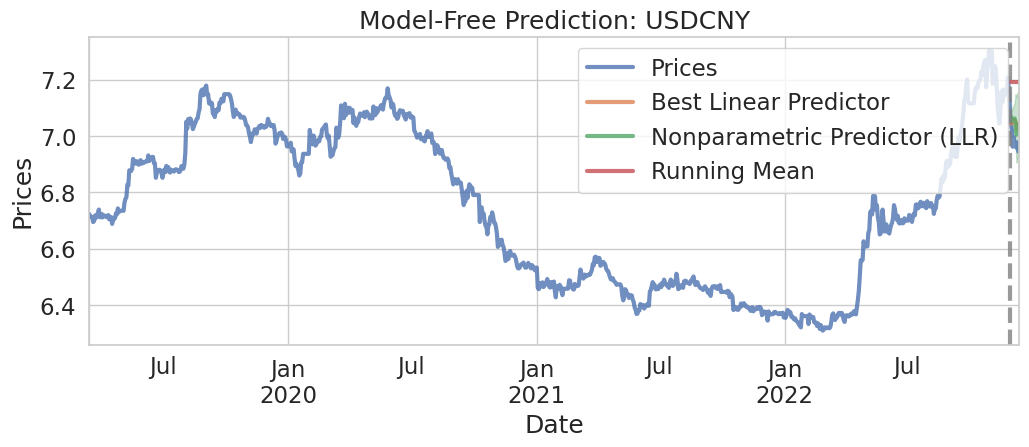

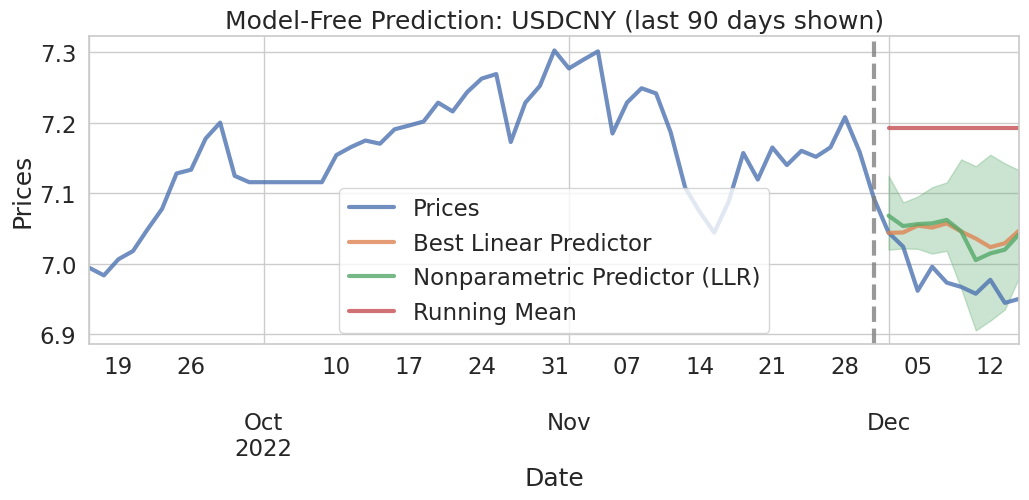

In [134]:
# plot for train + validation
prices = pd.Series(
    pd.concat([prices_train, prices_val], axis=0),
    name=PRICE_NAME,
)

predictions_val = {
    "Best Linear Predictor": (preds_lm_val, None, None),
    "Nonparametric Predictor (LLR)": (preds_llr_val, pi_lower_val, pi_upper_val),
    "Running Mean": (preds_mean_val, None, None),
}

for last_n_days in [None, 90]:
    ax = plot_ts_predictions(
        prices,
        predictions_val,
        split_date=TRAIN_END_DATE,
        last_n_days=last_n_days,
        linewidth=3,
        title=f"Model-Free Prediction: {SYMBOL}" + (
            "" if last_n_days is None else f" (last {last_n_days} days shown)"
        )
    )

Note that the prediction interval is only shown for the nonparametric predictor. (Computing the PI for the best linear predictor is left as an exercise.)

Both model-free predictors are much better than the running mean, which completely fails to capture the sharp decline at the beginning of the validation data. Between the best linear and nonparametric predictors, the difference is a bit hard to tell visually, although the nonparametric predictor models the decreasing patterns somewhat better.

In general, it would take a careful examination of the real-world events around this time to adequately explain such a drop in the exchange rate.

### Final Evaluation on the Test Set

To finally evaluate all methods the test set, we now update the running mean predictors to include the validation set during training. For the LLR predictor, the optimal hyperparameters are used directly.

In [135]:
prices_tv = pd.concat([prices_train, prices_val], axis=0)

linear_model = ModelFreeLinearPredictor(prices_tv).fit()
llr_model = ModelFreeNonparametricPredictor(
    prices_tv,
    window_size=best_window,
    bandwidth=best_bw,
    compute_interval=True,
).fit()
running_mean = np.mean(prices_tv[-linear_model.window_size:])

Test MSE, Best Linear Predictor: 0.00382
Test MSE, Nonparametric Predictor (LLR): 0.00276
Test MSE, Running Mean: 0.02329


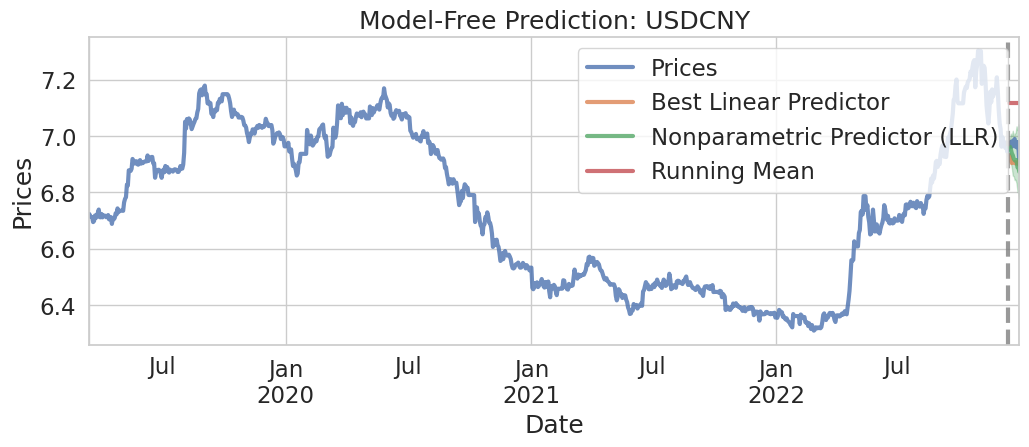

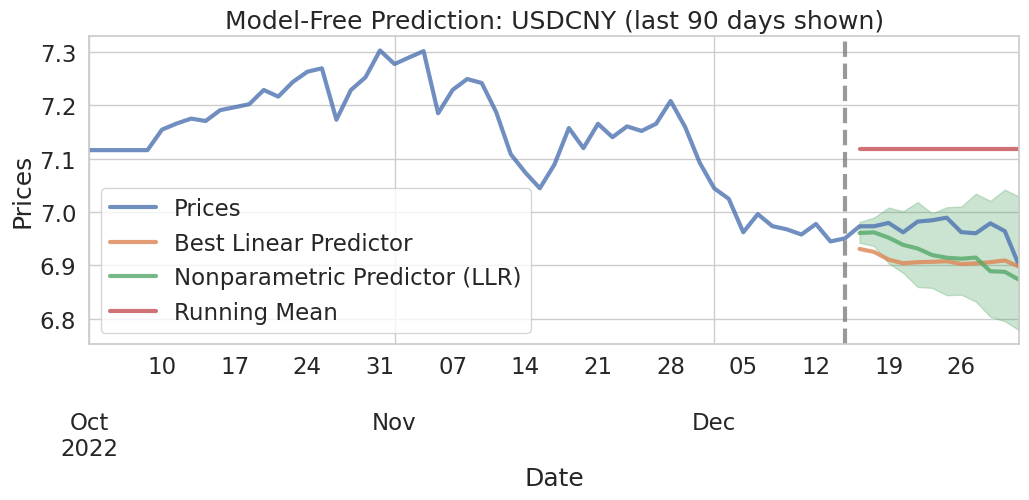

In [136]:
# plot for train AND validation -> test
prices = pd.Series(
    pd.concat([prices_train, prices_val, prices_test], axis=0),
    name=PRICE_NAME,
)

preds_lm_test = linear_model.forecast(t_index=prices_test.index)
preds_llr_test, pi_lower_test, pi_upper_test = llr_model.forecast(
    t_index=prices_test.index,
    predictors=prices_tv[-best_llr_model.window_size:],
)
preds_mean_test = pd.Series(
    data=np.repeat(running_mean, len(prices_test)),
    index=prices_test.index,
)
predictions_test = {
    "Best Linear Predictor": (preds_lm_test, None, None),
    "Nonparametric Predictor (LLR)": (preds_llr_test, pi_lower_test, pi_upper_test),
    "Running Mean": (preds_mean_test, None, None),
}
for predictor, (preds_test, _, _) in predictions_test.items():
    mse_test = mse(preds_test, prices_test)
    print("Test MSE, {}: {:.5f}".format(predictor, mse_test))

for last_n_days in [None, 90]:
    ax = plot_ts_predictions(
        prices,
        predictions_test,
        split_date=VAL_END_DATE,
        last_n_days=last_n_days,
        title=f"Model-Free Prediction: {SYMBOL}" + (
            "" if last_n_days is None else f" (last {last_n_days} days shown)"
        )
    )
    plt.savefig("./plots/ModelFreePrediction-{}-{}Day-{}{}.pdf".format(
        SYMBOL, PERIOD, PRICE_NAME, "" if last_n_days is None else "ZoomedIn",
    ))

On the test set, the nonparametric predictor achieves about 30% better MSE on the test set than the best linear predictor.
It appears that the best linear predictor follows the decreasing trend in early December "too closely," while the nonparametric predictor stays closer to the constant fluctuations during mid-December.

The prediction intervals look more reasonable here, as they become wider for larger forecasting horizons and capture the true price process.

### *Adding In-sample Predictions (NOT forecasts!)

To better understand the predictions, we can also try plotting the in-sample predictions for $X_{[\sqrt{T}]+k}, \dotsc, X_T$ for each value of $k$. We use $k=1$ here.

From a generalization point-of-view, the in-sample performance is just the training error from the curve fitting process, and it is _not_ indicative of how good the forecasts will be.
If anything, it corresponds to the degree of overfitting/interpolation (which may or may not be good).

In [137]:
k = 1
preds_lm_in = linear_model.predict_in_sample(k)
mse_lm_in = mse(preds_lm_in, linear_model.xs[linear_model.window_size:])
print("In-sample MSE, best linear predictor: {:.5f}".format(mse_lm_in))

In-sample MSE, best linear predictor: 0.00036


In [138]:
k = 1
preds_llr_in = llr_model.predict_in_sample(k)
mse_llr_in = mse(preds_llr_in, llr_model.xs[llr_model.window_size:])
print("In-sample MSE, nonparametric predictor: {:.5f}".format(mse_llr_in))

In-sample MSE, nonparametric predictor: 0.00034


In [139]:
# sliding window mean baseline. (weaker than the entire-window mean predictor)
windows = sliding_window_view(linear_model.xs,
                              linear_model.window_size)[:-1, :]
preds_mean_in = windows.mean(axis=1)
mse_mean_in = mse(preds_mean_in, linear_model.xs[linear_model.window_size:])
print("In-sample MSE, running mean predictor: {:.5f}".format(mse_mean_in))

In-sample MSE, running mean predictor: 0.00569


The in-sample MSEs are actually comparable between the two model-free predictors (still much better than the running mean).

We can also compare their fits visually:

In [140]:
# convert to pd.Series with proper index.
index_in = linear_model.xs[linear_model.window_size:].index
preds_lm_in = pd.Series(data=preds_lm_in, index=index_in)
preds_llr_in = pd.Series(data=preds_llr_in, index=index_in)
preds_mean_in = pd.Series(data=preds_mean_in, index=index_in)

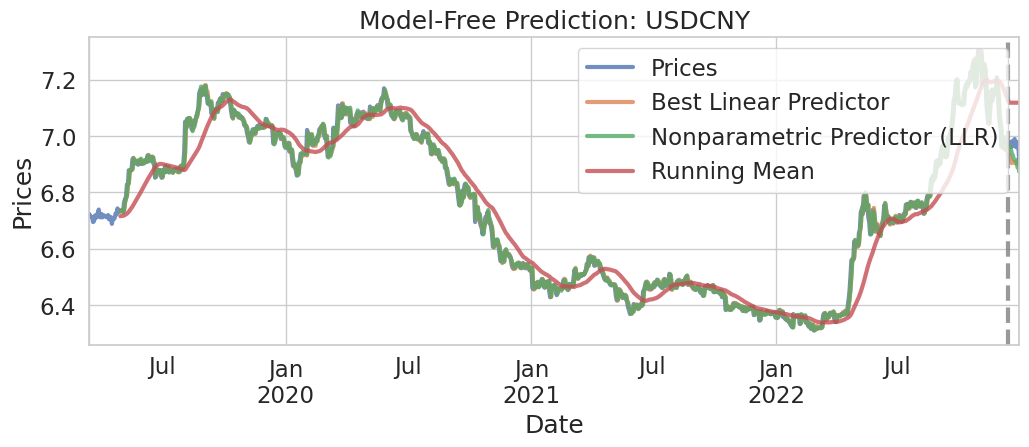

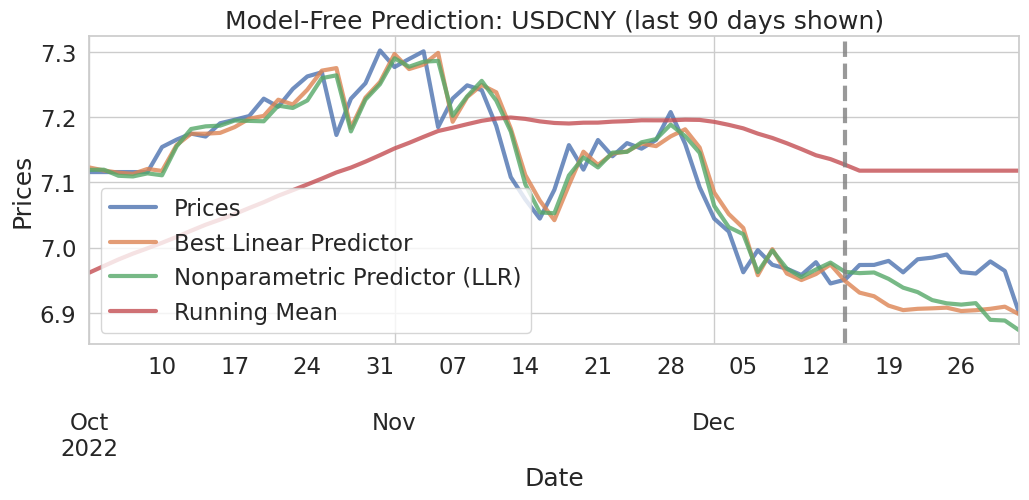

In [141]:
predictions_all = {
    "Best Linear Predictor": (pd.concat([preds_lm_in, preds_lm_test], axis=0), None, None),
    "Nonparametric Predictor (LLR)": (pd.concat([preds_llr_in, preds_llr_test], axis=0), None, None),
    "Running Mean": (pd.concat([preds_mean_in, preds_mean_test], axis=0), None, None),
}

for last_n_days in [None, 90]:
    ax = plot_ts_predictions(
        prices,
        predictions_all,
        split_date=VAL_END_DATE,
        last_n_days=last_n_days,
        title=f"Model-Free Prediction: {SYMBOL}" + (
            "" if last_n_days is None else f" (last {last_n_days} days shown)"
        )
    )
    plt.savefig("./plots/ModelFreePrediction-{}-{}Day-{}-InSample{}.pdf".format(
        SYMBOL, PERIOD, PRICE_NAME, "" if last_n_days is None else "ZoomedIn",
    ))

The nonparametric predictor and the best linear predictor at $k=1$ predict relatively similarly in-sample. The running mean predictor is way too smooth.

Note that these are the _in-sample_ predictions, not the forecasts.
As shown above, these explanations about in-sample predictions are not necessarily indicative of the forecast performance.

### Limitations

- Kernel regression methods (including LLR) become a lot less computationally efficient as the training data size ($\propto T$) increases. We'd want to consider alternatives if $T$ is too large.
- Tuning the hyperparameters can be computationally costly in other settings.
- At the end of the day, you can only forecast so well by just looking at a univariate time series of real-world financial assets. Incorporating other relevant features (e.g., information from other relevant stocks; external variables) is crucial in real-world forecasts.
- Even when using other features, real-world financial assets can be very challenging to predict, and even the weaker assumptions need not be met. Always proceed with caution.

### Exercises

- See the source code for the model-free predictors in `forecasters.py`, especially if you are not familiar with object-oriented programming in Python.
- Repeat this experiment with relative and log returns. What changes? How well does the best linear predictor work now?
- Repeat this experiment with the DJIA stock prices (divided by a thousand) as follows: first set the test data range from 2022-12-15 to 2022-12-31, and then adjust the test data range from 2023-03-01 to 2023-03-14 (using the previous 3-year data as training and validation sets). What changes? Can you explain what can and can't be done with the prediction framework as-is?